Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install ..  # installing d2l
!pip install -U mxnet-cu101==1.7.0


# 培训前培训 BERT
:label:`sec_bert-pretraining`

随着在 :numref:`sec_bert` 中实施了 BERT 模型，以及 :numref:`sec_bert-dataset` 中从 WikiText-2 数据集生成的预训练示例，我们将在本节的 WikiText-2 数据集上预训练 BERT。


In [1]:
from mxnet import autograd, gluon, init, np, npx
from d2l import mxnet as d2l

npx.set_np()

首先，我们加载 Wikitext-2 数据集作为用于掩码语言建模和下一句话预测的预训练示例的小组。批次大小为 512，BERT 输入序列的最大长度为 64。请注意，在原始的 BERT 模型中，最大长度为 512。


In [2]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

## 培训前培训 BERT

原来的 BERT 有两个不同型号尺寸 :cite:`Devlin.Chang.Lee.ea.2018` 的版本。基本型号（$\text{BERT}_{\text{BASE}}$）使用 12 层（变压器编码器块），其中包含 768 个隐藏单元（隐藏尺寸）和 12 个自我注意头。大型模型（$\text{BERT}_{\text{LARGE}}$）使用 24 层，其中有 1024 个隐藏单元和 16 个自我注意头。值得注意的是，前者有 1.1 亿个参数，而后者有 3.4 亿个参数。为了轻松进行演示，我们定义了一个小型 BERT，它使用 2 层、128 个隐藏单位和 2 个自我注意头。


In [3]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, ffn_num_hiddens=256,
                    num_heads=2, num_layers=2, dropout=0.2)
devices = d2l.try_all_gpus()
net.initialize(init.Xavier(), ctx=devices)
loss = gluon.loss.SoftmaxCELoss()

在定义训练循环之前，我们定义了一个助手函数 `_get_batch_loss_bert`。鉴于训练示例的数量，此函数计算蒙版语言建模和下一句预测任务的损失。请注意，BERT 预训练的最后损失只是蒙版语言建模损失和下一句预测损失的总和。


In [4]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X_shards,
                         segments_X_shards, valid_lens_x_shards,
                         pred_positions_X_shards, mlm_weights_X_shards,
                         mlm_Y_shards, nsp_y_shards):
    mlm_ls, nsp_ls, ls = [], [], []
    for (tokens_X_shard, segments_X_shard, valid_lens_x_shard,
         pred_positions_X_shard, mlm_weights_X_shard, mlm_Y_shard,
         nsp_y_shard) in zip(tokens_X_shards, segments_X_shards,
                             valid_lens_x_shards, pred_positions_X_shards,
                             mlm_weights_X_shards, mlm_Y_shards,
                             nsp_y_shards):
        # Forward pass
        _, mlm_Y_hat, nsp_Y_hat = net(tokens_X_shard, segments_X_shard,
                                      valid_lens_x_shard.reshape(-1),
                                      pred_positions_X_shard)
        # Compute masked language model loss
        mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)),
                     mlm_Y_shard.reshape(-1),
                     mlm_weights_X_shard.reshape((-1, 1)))
        mlm_l = mlm_l.sum() / (mlm_weights_X_shard.sum() + 1e-8)
        # Compute next sentence prediction loss
        nsp_l = loss(nsp_Y_hat, nsp_y_shard)
        nsp_l = nsp_l.mean()
        mlm_ls.append(mlm_l)
        nsp_ls.append(nsp_l)
        ls.append(mlm_l + nsp_l)
        npx.waitall()
    return mlm_ls, nsp_ls, ls

调用上述两个辅助函数，以下 `train_bert` 函数定义了在 Wikitext-2 (`train_iter`) 数据集上预训练 BERT (`net`) 的过程。培训 BERT 可能需要很长时间。以下函数的输入 `num_steps` 没有像 `train_ch13` 函数那样指定训练的时代数量（参见 :numref:`sec_image_augmentation`），而是指定训练的迭代步数。


In [5]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': 1e-3})
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss', xlim=[1, num_steps],
                            legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for batch in train_iter:
            (tokens_X_shards, segments_X_shards, valid_lens_x_shards,
             pred_positions_X_shards, mlm_weights_X_shards, mlm_Y_shards,
             nsp_y_shards) = [
                 gluon.utils.split_and_load(elem, devices, even_split=False)
                 for elem in batch]
            timer.start()
            with autograd.record():
                mlm_ls, nsp_ls, ls = _get_batch_loss_bert(
                    net, loss, vocab_size, tokens_X_shards, segments_X_shards,
                    valid_lens_x_shards, pred_positions_X_shards,
                    mlm_weights_X_shards, mlm_Y_shards, nsp_y_shards)
            for l in ls:
                l.backward()
            trainer.step(1)
            mlm_l_mean = sum([float(l) for l in mlm_ls]) / len(mlm_ls)
            nsp_l_mean = sum([float(l) for l in nsp_ls]) / len(nsp_ls)
            metric.add(mlm_l_mean, nsp_l_mean, batch[0].shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

我们可以绘制 BERT 预训期间的蒙版语言建模损失和下一句话预测损失。


MLM loss 7.899, NSP loss 0.730
4658.0 sentence pairs/sec on [gpu(0), gpu(1)]


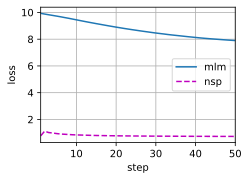

In [6]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

## 用 BERT 表示文本

在预训练 BERT 之后，我们可以用它来表示单个文本、文本对或其中的任何标记。以下函数返回 `tokens_a` 和 `tokens_b` 中所有令牌的 BERT (`net`) 表示形式。


In [7]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = np.expand_dims(np.array(vocab[tokens], ctx=devices[0]),
                               axis=0)
    segments = np.expand_dims(np.array(segments, ctx=devices[0]), axis=0)
    valid_len = np.expand_dims(np.array(len(tokens), ctx=devices[0]), axis=0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

考虑一下 “起重机在飞” 这句话。回想一下 :numref:`subsec_bert_input_rep` 中讨论的 BERT 的输入表示形式。插入特殊标记 “<cls>”（用于分类）和 “<sep>”（用于分隔）后，BERT 输入序列的长度为 6。由于零是 “<cls>” 令牌的索引，所以 `encoded_text[:, 0, :]` 是整个输入句子的 BERT 表示。为了评估 polysemy 令牌 “鹤”，我们还打印了代币 BERT 表示的前三个元素。


In [8]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

((1, 6, 128),
 (1, 128),
 array([ 0.5760898,  0.8728954, -0.7348441], ctx=gpu(0)))

现在考虑一对句子 “起重机司机来了” 和 “他刚离开”。同样，`encoded_pair[:, 0, :]` 是预训练的 BERT 整个句子对的编码结果。请注意，polysemy 令牌 “鹤” 的前三个元素与上下文不同时的前三个元素不同。这支持 BERT 表示是上下文相关的。


In [9]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

((1, 10, 128),
 (1, 128),
 array([ 0.52430856,  0.91359675, -0.7947666 ], ctx=gpu(0)))

在 :numref:`chap_nlp_app` 中，我们将为下游自然语言处理应用程序微调预训练的 BERT 模型。 

## 摘要

* 原来的 BERT 有两个版本，其中基本模型有 1.1 亿个参数，而大型模型有 3.4 亿个参数。
* 在预训练 BERT 之后，我们可以用它来表示单个文本、文本对或其中的任何标记。
* 在实验中，当上下文不同时，同一个令牌具有不同的 BERT 表示形式。这支持 BERT 表示是上下文相关的。

## 练习

1. 在实验中，我们可以看到，蒙版语言建模损失明显高于下一个句子预测损失。为什么？
2. 将 BERT 输入序列的最大长度设置为 512（与原始 BERT 模型相同）。使用原始 BERT 模型的配置，例如 $\text{BERT}_{\text{LARGE}}$。运行此部分时你会遇到任何错误吗？为什么？


[Discussions](https://discuss.d2l.ai/t/390)
